##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [1]:
!pip install colorama
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt


##  <font color=MediumSlateBlue>Directions</font> ##

In [2]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

##  <font color=MediumSlateBlue>Environment</font> ##

In [3]:
class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      # P[s][a] = (prob, next_state, reward, is_done)
      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,45,63,64]
      no_down = lambda s: s in [23,24,25,44]
      no_left = lambda s: s in [44,36,55]
      no_right = lambda s: s in [32,42,52]

      #Barries in the path
      pit = lambda s: s in [13,62,41]
      wall = lambda s: s in [43,33,53,34,35,54]

      #Rewards of each state
      reward = 1.0 if is_done(s) else 0.0
      reward = -10.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -3.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -3.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -3.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -3.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,62,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,62,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,35,54]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

##  <font color=MediumSlateBlue>How to use the above class?</font> ##

In [4]:
env =  GridworldEnv()
env.reset()
env._render()

for _ in range(3):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # Take a random action
    print(state)
    print('action:',action)
    #env._render()
env.close()


       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
44
action: 0
44
action: 3
44
action: 3


In [5]:
# initilize Q table
Q_table = np.zeros((env.observation_space.n,env.action_space.n))
# parameters
decay = 0.999
gamma = 0.99
learning_rate = 0.5
prob_epi=1.0
epi_rewards=[]
for _ in range(10000):
    current_state = env.reset()
    done = False
    sum_rewards_epi = 0
    iters=1
    for _ in range(100):
        if  prob_epi > np.random.rand() :
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
        next_state, reward, done, _ = env.step(action)
        Q_table[current_state, action] = (1-learning_rate) * Q_table[current_state, action] +learning_rate*(reward + gamma*max(Q_table[next_state,:]))
        sum_rewards_epi = sum_rewards_epi + reward
        if done:
            _, reward, _, _ = env.step(0)
            Q_table[current_state, action] = (1-learning_rate) * Q_table[current_state, action] +learning_rate*(reward + gamma*max(Q_table[next_state,:]))
            sum_rewards_epi += reward
            break
        if reward==-10:
          current_state=env.reset()
        else:
          current_state = next_state
    prob_epi*=decay
    prob_epi = max(0.001, prob_epi)
    epi_rewards.append(sum_rewards_epi)

In [6]:

print(Q_table)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.60000000e-01  6.53400000e-01  6.53400000e-01  6.66666667e-01]
 [ 6.53400000e-01  6.46866000e-01  6.46866000e-01  6.60000000e-01]
 [ 6.46866000e-01  6.40397340e-01 -9.25960266e+00  6.53400000e-01]
 [ 6.40397340e-01  6.33993367e-01  6.33993367e-01  6.46866000e-01]
 [ 6.33993367e-01  6.27653433e-01  6.27653433e-01  6.40397340e-01]
 [ 6.27653433e-01  6.21376899e-01  6.21376899e-01  6.33993367e-01]
 [ 6.21376899e-01  6.15163130e-01  6.15163130e-01  6.27653433e-01]
 [ 6.15163130e-01  6.09011498e-01  6.09011498e-01  6.21376899e-01]
 [ 6.09011498e-01  6.09011353e-01  6.02921383e-01  6.15163130e-01]
 [ 6.66666667e-01  6.53400000e-01  6.53399994e-01  6.59999998e-01]
 [ 6.60000000e-01  6.46865999e-01  6.46866000e-01  6.60000000e-01]
 [ 6.53400000e-01 -9.25960266e+00  6.40397340e-01  6.53400000e-01]
 [-9.35313400e+00 -9.36600663e+00 -9.36600775e+00 -9.35313400e+00]
 [ 6.40397340e-01  6.27653433e-01  6.27653433e-01 -9.25960266e

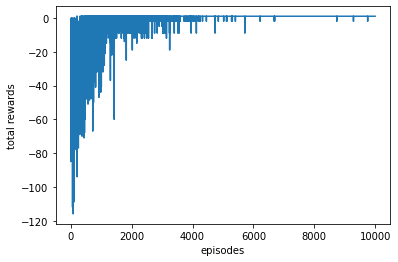

1.0


In [7]:
plt.plot(epi_rewards)
plt.xlabel("episodes")
plt.ylabel("total rewards")
plt.show()
print(epi_rewards[9999])

In [8]:
# testing trained model
env.reset()
state=44
env._render()
for _ in range(12):
    action = np.argmax(Q_table[state,:])
    state, reward, done, info = env.step(action) # Take a random action
    print("state: ", state)
    print('action:',action)
    env._render()
env.close()

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
state:  45
action: 1
       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    웃   .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    

In [9]:
# testing convergence with more decay probability
# initilize Q table
Q_table = np.zeros((env.observation_space.n,env.action_space.n))
# parameters
decay = 0.99
gamma = 0.99
learning_rate = 0.5
prob_epi=1.0
epi_rewards=[]
for _ in range(10000):
    current_state = env.reset()
    done = False
    sum_rewards_epi = 0
    iters=1
    for _ in range(100):
        if  prob_epi > np.random.rand() :
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
        next_state, reward, done, _ = env.step(action)
        Q_table[current_state, action] = (1-learning_rate) * Q_table[current_state, action] +learning_rate*(reward + gamma*max(Q_table[next_state,:]))
        sum_rewards_epi = sum_rewards_epi + reward
        if done:
            _, reward, _, _ = env.step(0)
            Q_table[current_state, action] = (1-learning_rate) * Q_table[current_state, action] +learning_rate*(reward + gamma*max(Q_table[next_state,:]))
            sum_rewards_epi += reward
            break
        if reward==-10:
          current_state=env.reset()
        else:
          current_state = next_state
    prob_epi*=decay
    prob_epi = max(0.001, prob_epi)
    epi_rewards.append(sum_rewards_epi)

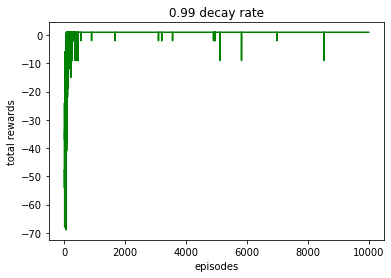

In [10]:
plt.plot(epi_rewards,'g')
plt.xlabel("episodes")
plt.ylabel("total rewards")
plt.title("0.99 decay rate")
plt.show()

In [11]:
# testing convergence with more end reward
# initilize Q table
Q_table = np.zeros((env.observation_space.n,env.action_space.n))
# parameters
decay = 0.999
gamma = 0.99
learning_rate = 0.5
prob_epi=1.0
epi_rewards=[]
for _ in range(10000):
    current_state = env.reset()
    done = False
    sum_rewards_epi = 0
    iters=1
    for _ in range(100):
        if  prob_epi > np.random.rand() :
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
        next_state, reward, done, _ = env.step(action)
        Q_table[current_state, action] = (1-learning_rate) * Q_table[current_state, action] +learning_rate*(reward + gamma*max(Q_table[next_state,:]))
        sum_rewards_epi = sum_rewards_epi + reward
        if done:
            _, reward, _, _ = env.step(0)
            reward=10
            Q_table[current_state, action] = (1-learning_rate) * Q_table[current_state, action] +learning_rate*(reward + gamma*max(Q_table[next_state,:]))
            sum_rewards_epi += reward
            break
        if reward==-10:
          current_state=env.reset()
        else:
          current_state = next_state
    prob_epi*=decay
    prob_epi = max(0.001, prob_epi)
    epi_rewards.append(sum_rewards_epi)

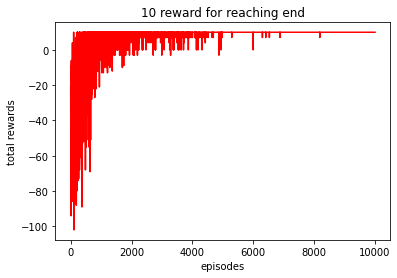

10.0


In [12]:
plt.plot(epi_rewards,'r')
plt.xlabel("episodes")
plt.ylabel("total rewards")
plt.title("10 reward for reaching end")
plt.show()
print(epi_rewards[9999])

In [13]:
# testing convergence with punishment for steps
# initilize Q table
Q_table = np.zeros((env.observation_space.n,env.action_space.n))
# parameters
decay = 0.999
gamma = 0.99
learning_rate = 0.5
prob_epi=1.0
epi_rewards=[]
iters_epi=[]
for _ in range(10000):
    current_state = env.reset()
    done = False
    sum_rewards_epi = 0
    iters=1
    for i in range(100):
        if  prob_epi > np.random.rand() :
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
        next_state, reward, done, _ = env.step(action)
        if reward == 0:
          reward=-0.1
        Q_table[current_state, action] = (1-learning_rate) * Q_table[current_state, action] +learning_rate*(reward + gamma*max(Q_table[next_state,:]))
        sum_rewards_epi = sum_rewards_epi + reward
        if done:
            _, reward, _, _ = env.step(0)
            Q_table[current_state, action] = (1-learning_rate) * Q_table[current_state, action] +learning_rate*(reward + gamma*max(Q_table[next_state,:]))
            sum_rewards_epi += reward
            break
        if reward==-10:
          current_state=env.reset()
        else:
          current_state = next_state
    iters_epi.append(i)
    prob_epi*=decay
    prob_epi = max(0.001, prob_epi)
    epi_rewards.append(sum_rewards_epi)

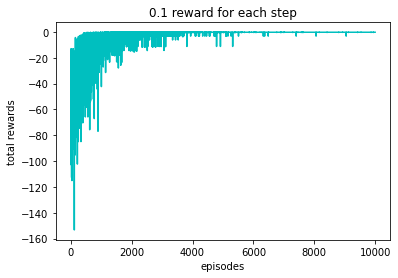

-0.19999999999999996


In [14]:
plt.plot(epi_rewards,'c')
plt.xlabel("episodes")
plt.ylabel("total rewards")
plt.title("0.1 reward for each step")
plt.show()
print(epi_rewards[9999])